In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 15.0 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
# env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x % 100 == 0)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on Device", device)

def plot_rewards(rewards, mode = "Training"):
  # Reward Dynamics
  plt.figure(figsize=(15, 15))
  plt.plot(rewards)
  plt.xlabel('Episode', fontsize=28)
  plt.ylabel('Reward Value', fontsize=28)
  plt.title(mode, fontsize=36)
  plt.xticks(fontsize=24)
  plt.yticks( fontsize=24)
  plt.grid()
  plt.show()

Running on Device cuda


In [ ]:
# Neural network that takes in a state and gives probability distro for all actions
class Actor_net(nn.Module):
    def __init__(self, obs_size, no_actions):
        super(Actor_net, self).__init__()
        self.fc1 = nn.Linear(obs_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, no_actions)

    def forward(self, x):
        state = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim = 0)
        action_dist = torch.distributions.Categorical(x)
        action = action_dist.sample()
        return action, torch.log(x[action]) # log Prob of action with highest prob

# Neural network that takes in a state and action and produces Q values
class Critic_net(nn.Module):
    def __init__(self, obs_size):
        super(Critic_net, self).__init__()
        self.fc1 = nn.Linear(obs_size + 1, 128) # observation plus action
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



Streaming output truncated to the last 5000 lines.
reward after episode 1: 27.0 
reward after episode 2: 36.0 
reward after episode 3: 16.0 
reward after episode 4: 13.0 
reward after episode 5: 51.0 
reward after episode 6: 11.0 
reward after episode 7: 26.0 
reward after episode 8: 23.0 
reward after episode 9: 53.0 
reward after episode 10: 44.0 
reward after episode 11: 14.0 
reward after episode 12: 20.0 
reward after episode 13: 14.0 
reward after episode 14: 57.0 
reward after episode 15: 74.0 
reward after episode 16: 11.0 
reward after episode 17: 20.0 
reward after episode 18: 39.0 
reward after episode 19: 24.0 
reward after episode 20: 31.0 
reward after episode 21: 10.0 
reward after episode 22: 49.0 
reward after episode 23: 23.0 
reward after episode 24: 42.0 
reward after episode 25: 39.0 
reward after episode 26: 31.0 
reward after episode 27: 28.0 
reward after episode 28: 39.0 
reward after episode 29: 28.0 
reward after episode 30: 46.0 
reward after episode 31: 41.

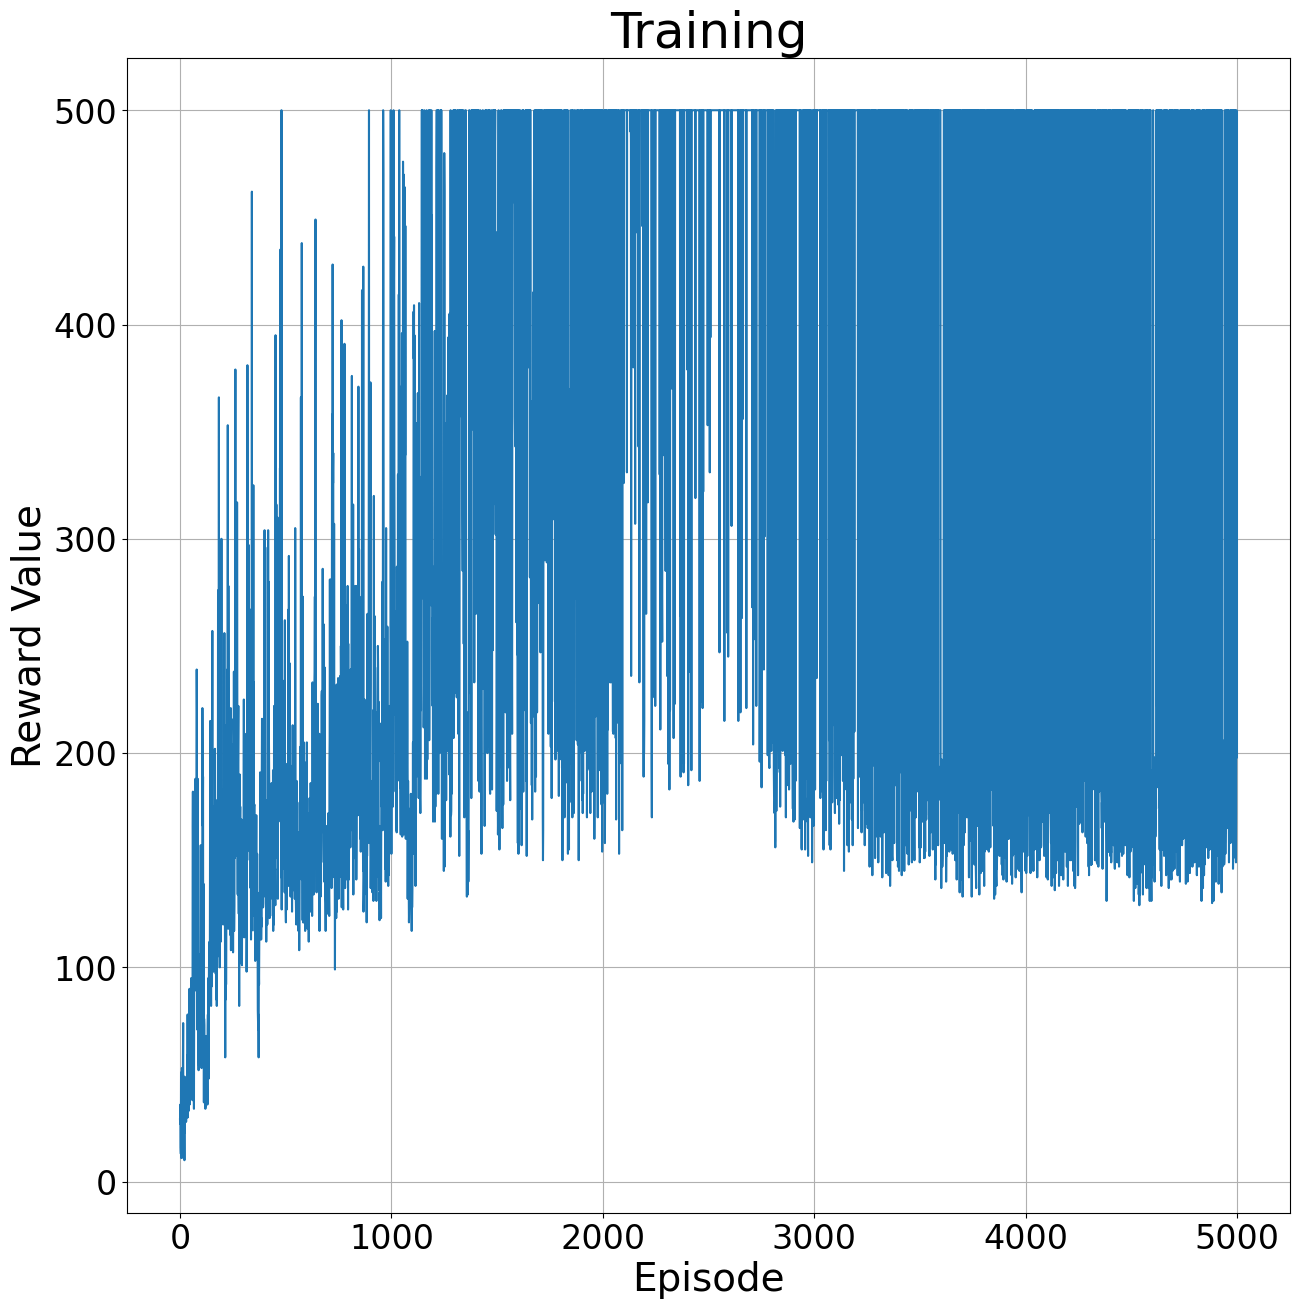

In [ ]:
# Inititalization and parameters
gamma = 0.99 # discount factor
no_episodes = 5000

# results stored here
reward_per_episode_train = []
actor_loss = []
critic_loss = []
actions = []
# Init Q net and target Q net
actor = Actor_net(4, 2).to(device) # NN takes in obs and gives prob for different action
critic = Critic_net(4).to(device) # NN that Takes obs, and action and gives Q val

# Loss function for critic setup
criterion = nn.MSELoss() # MSE loss

optimizer_actor = optim.Adam(actor.parameters(), lr=0.00009) # stochastic gradient descent to calculate updated weights
optimizer_critic = optim.Adam(critic.parameters(), lr=0.00009) # stochastic gradient descent to calculate updated weights

# 4. Loop for multiple episodes.
for e in range(no_episodes):
  # 5. Initialize the state.
  next_state, _ = env.reset()
  next_state = torch.tensor(next_state, device=device)
  # 7. Pick an action suggested by actor network
  next_action, next_log_prob = actor(next_state)

  episode_reward, terminated, truncated = 0, False, False
  # 6. Until the episode ends
  while not terminated and not truncated:
    # new_state from the previous iteration is the current state now.
    curr_state = next_state
    curr_action = next_action
    actions.append(curr_action)
    curr_log_prob = next_log_prob

    # Take action
    next_state, reward, terminated, truncated, _ = env.step(curr_action.item())
    episode_reward += reward
    reward -= (abs(next_state[2]) + abs(next_state[3]))
    next_state = torch.tensor(next_state, device=device)


    # Actor gives the next_action and log probabilities of all actions
    next_action, next_log_prob = actor(next_state)

    # Q_val of current state
    Q_val = critic(torch.cat((curr_state,torch.tensor([curr_action], device = device)),0))

    # Compute TD error (target)
    target =  reward + gamma * critic(torch.cat((next_state,torch.tensor([next_action], device=device)),0))
    td_err = target - Q_val

    # Update actor parameters based on Q value and log probability
    # Reset the leftover gradient
    optimizer_actor.zero_grad()
    # Calculate loss (minus because gradient ascent) try td error here
    loss_actor = - curr_log_prob * td_err.detach()
    # Calculate the delta IG
    loss_actor.backward()
    # Pass the loss to all the nodes
    optimizer_actor.step()


    # Reset the leftover gradient
    optimizer_critic.zero_grad()
    # Calculate critic loss
    # loss_critic = td_err.detach() * Q_val
    loss_critic = criterion(Q_val , target)
    # Calculate the gradient and store it in grad of each param
    loss_critic.backward()
    # Adjust each weight by it's gradient stored in grad
    optimizer_critic.step()



  reward_per_episode_train.append(episode_reward)
  print("reward after episode {0}: {1} ".format(e, episode_reward) )
print("last 10 rewards: \n", reward_per_episode_train[-10:], terminated)

plot_rewards(reward_per_episode_train)
# Save weights at the end
WEIGHTS_ACTOR_PATH = "./actor"
WEIGHTS_CRITIC_PATH = "./critic"

torch.save(actor.state_dict(), WEIGHTS_ACTOR_PATH)
torch.save(critic.state_dict(), WEIGHTS_CRITIC_PATH)

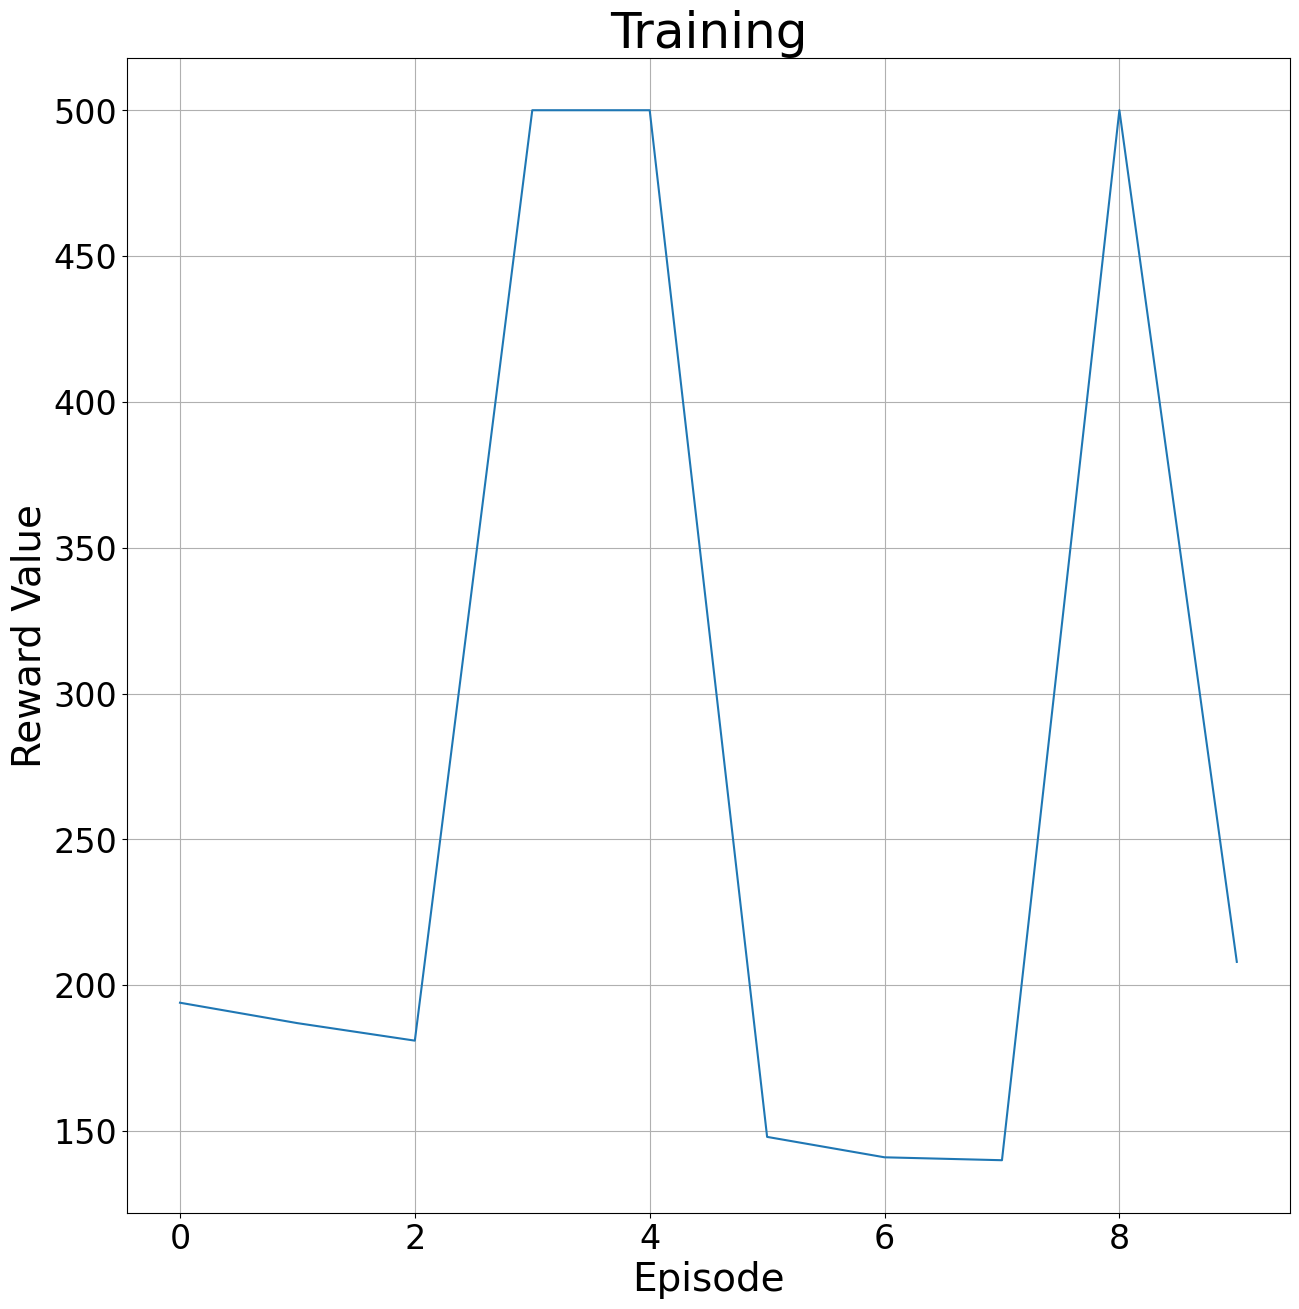

In [ ]:
best_reward = 0
running_reward = 0

gamma = 0.99 # discount factor
no_episodes = 10

# results stored here
reward_per_episode_test = []
# Init Q net and target Q net
actor = Actor_net(4, 2).to(device) # NN takes in obs and gives prob for different action
# Load existing weights when training crashes
actor.load_state_dict(torch.load(WEIGHTS_ACTOR_PATH))

optimizer_actor = optim.Adam(actor.parameters(), lr=0.00009) # stochastic gradient descent to calculate updated weights

# 4. Loop for multiple episodes.
for e in range(no_episodes):
  # 5. Initialize the state.
  next_state, _ = env.reset()
  next_state = torch.tensor(next_state, device=device)
  # 7. Pick an action suggested by actor network
  next_action, next_log_prob = actor(next_state)

  episode_reward, terminated, truncated = 0, False, False
  # 6. Until the episode ends
  while not terminated and not truncated:
    # new_state from the previous iteration is the current state now.
    curr_state = next_state
    curr_action = next_action
    curr_log_prob = next_log_prob

    # Take action
    next_state, reward, terminated, truncated, _ = env.step(curr_action.item())
    episode_reward += reward
    next_state = torch.tensor(next_state, device=device)

    # Actor gives the next_action and log probabilities of all actions
    next_action, next_log_prob = actor(next_state)

  reward_per_episode_test.append(episode_reward)

plot_rewards(reward_per_episode_test)
